## CREDIT CARD FRAUD TRANSACTIONS

Summary

1. Joining all the tables with required columns and excluding the Customers without Card because we  need transactions for further steps.
2. Used dataprep for EDA and understanding the data information. EDA was challenging because of class imbalance of target.
3. After analysis on the data set selected Categorical columns for preprocessing, created new columns with encoding, changed the required dataType and at last merged the processed columns to the original dataFrame.
4. On observing the data information and comaparison with 'Fraud_Flag' few columns were dropped.
5. The data was ready with all required Independent Columns then target & features were selected.
6. As the data column's values are of different scale then Scaling was performed on the it.
7. The train_test split was completed on the scaled data for training on the LogisticRegression with imbalanced data and result was biased to label '0'.
8. For balancing the data SMOTE(Synthetic Minority Oversampling Technique) technique is used , after using this the class was balanced and then train_test split was performed on new synthetic data.
9. For finding the best model LogisticRegression, XGBoostClassifier, RandomForest, DecisionTreeClassifier and SVC were used. These model were tuned with best parameters with the help of GridSearchCV .
10. Among all the models SVC performed better and with reduced overfitting results.



In [506]:
# Importing the required Libraries and handling the warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [507]:
# Reading csv files and created DataFrames for each file

CardBase = pd.read_csv('CardBase.csv')
FraudBase = pd.read_csv('FraudBase.csv')
CustomerBase = pd.read_csv('CustomerBase.csv')
TransactionBase = pd.read_csv('TransactionBase.csv')


In [508]:
# Checking the column's name for joining them together

for colName in [CardBase,CustomerBase,FraudBase,TransactionBase]:
    print(colName.columns)
    

Index(['Card_Number', 'Card_Family', 'Credit_Limit', 'Cust_ID'], dtype='object')
Index(['Cust_ID', 'Age', 'Customer_Segment', 'Customer_Vintage_Group'], dtype='object')
Index(['Transaction_ID', 'Fraud_Flag'], dtype='object')
Index(['Transaction_ID', 'Transaction_Date', 'Credit_Card_ID',
       'Transaction_Value', 'Transaction_Segment'],
      dtype='object')


In [509]:
# Joined CardBase and CustomerBase with inner join. This filters the Customer with Card data.

cardCust = pd.merge(CardBase, CustomerBase, on='Cust_ID', how='inner')
cardCust.shape

(500, 7)

In [510]:
# Joined the TransactionBase with Fraudlent Transactions.

FraudTransc = pd.merge(FraudBase, TransactionBase, on='Transaction_ID', how = 'outer')

In [511]:
# Joined the two grouped tables for the final DataFrame

df = pd.merge(cardCust,FraudTransc, left_on=['Card_Number'],right_on=['Credit_Card_ID'], how='outer')

In [512]:
df.head()

,Card_Number,Card_Family,Credit_Limit,Cust_ID,Age,Customer_Segment,Customer_Vintage_Group,Transaction_ID,Fraud_Flag,Transaction_Date,Credit_Card_ID,Transaction_Value,Transaction_Segment
0,8638-5407-3631-8196,Premium,530000,CC67088,27,Diamond,VG1,CTID85973577,NaN,13-Feb-16,8638-5407-3631-8196,31592,SEG21
1,8638-5407-3631-8196,Premium,530000,CC67088,27,Diamond,VG1,CTID13215166,NaN,30-Oct-16,8638-5407-3631-8196,5894,SEG12
2,8638-5407-3631-8196,Premium,530000,CC67088,27,Diamond,VG1,CTID41016745,NaN,9-May-16,8638-5407-3631-8196,20925,SEG11
3,8638-5407-3631-8196,Premium,530000,CC67088,27,Diamond,VG1,CTID82512584,NaN,31-Aug-16,8638-5407-3631-8196,36556,SEG11
4,8638-5407-3631-8196,Premium,530000,CC67088,27,Diamond,VG1,CTID97222954,NaN,25-Nov-16,8638-5407-3631-8196,36715,SEG18


Data Information & Understanding using "dataprep" libraries

In [513]:
from dataprep.eda import create_report

#create_report(df)

Checking the Fraud_Flag count

In [514]:
df['Fraud_Flag'].value_counts()

1.0    109
Name: Fraud_Flag, dtype: int64

In [515]:
df['Fraud_Flag'].replace(np.NaN, 0, inplace=True)
df['Fraud_Flag'] = df['Fraud_Flag'].astype(np.int64)

In [516]:
df['Fraud_Flag'].value_counts()

0    9891
1     109
Name: Fraud_Flag, dtype: int64

In [517]:
# Checking the Null Values

df.isnull().sum()

Card_Number               0
Card_Family               0
Credit_Limit              0
Cust_ID                   0
Age                       0
Customer_Segment          0
Customer_Vintage_Group    0
Transaction_ID            0
Fraud_Flag                0
Transaction_Date          0
Credit_Card_ID            0
Transaction_Value         0
Transaction_Segment       0
dtype: int64

In [518]:
# Checking the DataType of the Column

df.dtypes

Card_Number               object
Card_Family               object
Credit_Limit               int64
Cust_ID                   object
Age                        int64
Customer_Segment          object
Customer_Vintage_Group    object
Transaction_ID            object
Fraud_Flag                 int64
Transaction_Date          object
Credit_Card_ID            object
Transaction_Value          int64
Transaction_Segment       object
dtype: object

In [519]:
# Checking the Correlation

df.corr()

,Credit_Limit,Age,Fraud_Flag,Transaction_Value
Credit_Limit,1.000000,-0.012878,-0.005704,-0.006661
Age,-0.012878,1.000000,-0.006525,-0.001739
Fraud_Flag,-0.005704,-0.006525,1.000000,0.014976
Transaction_Value,-0.006661,-0.001739,0.014976,1.000000


Observation of Categorical Values and processing 

In [520]:
df['Customer_Segment'].unique()

array(['Diamond', 'Gold', 'Platinum'], dtype=object)

In [521]:
df['Card_Family'].unique()

array(['Premium', 'Gold', 'Platinum'], dtype=object)

In [522]:
df['Customer_Vintage_Group'].unique()

array(['VG1', 'VG3', 'VG2'], dtype=object)

In [523]:
df['Transaction_Segment'].unique()


array(['SEG21', 'SEG12', 'SEG11', 'SEG18', 'SEG15', 'SEG23', 'SEG17',
       'SEG19', 'SEG16', 'SEG24', 'SEG14', 'SEG22', 'SEG25', 'SEG20',
       'SEG13'], dtype=object)

In [524]:
# adding the month, date and dayOfWeek columns to the dataset

df['Transaction_Month'] = pd.DatetimeIndex(df['Transaction_Date']).month
df['Transaction_Day'] = pd.DatetimeIndex(df['Transaction_Date']).day
df['Transaction_DayofWeek'] = pd.DatetimeIndex(df['Transaction_Date']).dayofweek


In [525]:
# Transaction_Date Conversion to DateTime

df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], format='%d-%b-%y')

Binning of the required Columns

In [526]:
(df['Credit_Limit']/1000).unique().max(),(df['Credit_Limit']/1000).unique().min()

(899.0, 2.0)

In [527]:
df['Credit_Limit'] = pd.cut(df['Credit_Limit']/1000, 
                           bins = [1,200,400,600,800,1000], labels=['1_200','200_400','400_600','600_800','800_1000'] )

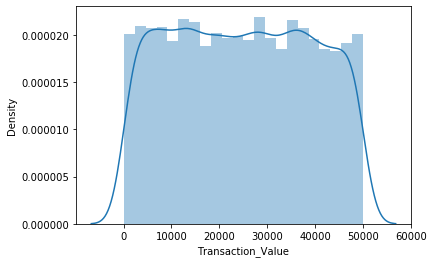

In [528]:
# Ploting for Distribution of data 

sns.distplot(df['Transaction_Value'], hist=True)

In [529]:
(df['Transaction_Value']).unique().max(),(df['Transaction_Value']/1000).unique().min()

(49995, 0.103)

In [530]:
df['Transaction_Value'] = pd.cut(df['Transaction_Value'], 
                           bins = [1,10000,20000,30000,40000,50000,60000], labels=['0_10','10_20','20_30','30_40','40_50','50-60'] )

In [531]:
# Using One-Hot Encoding for all Categorical Columns 

cat_df = df[['Customer_Segment','Card_Family','Transaction_Segment','Credit_Limit','Transaction_Value']]

In [532]:
for col in cat_df.columns:
    cat_df = pd.get_dummies(cat_df, columns=[col], prefix = str(col))
    

In [533]:
cat_df.shape

(10000, 32)

In [534]:
# combining the categorical dataframes with original DataFrame to get the final dataset

df=pd.concat([df,cat_df], axis=1)

In [535]:
df.shape

(10000, 48)

In [537]:
# Checking the DataTypes

df.dtypes

Card_Number                          object
Card_Family                          object
Credit_Limit                       category
Cust_ID                              object
Age                                   int64
Customer_Segment                     object
Customer_Vintage_Group               object
Transaction_ID                       object
Fraud_Flag                            int64
Transaction_Date             datetime64[ns]
Credit_Card_ID                       object
Transaction_Value                  category
Transaction_Segment                  object
Transaction_Month                     int64
Transaction_Day                       int64
Transaction_DayofWeek                 int64
Customer_Segment_Diamond              uint8
Customer_Segment_Gold                 uint8
Customer_Segment_Platinum             uint8
Card_Family_Gold                      uint8
Card_Family_Platinum                  uint8
Card_Family_Premium                   uint8
Transaction_Segment_SEG11       

In [538]:
# After Evaluation of each column with respect to Fraud_Flag below columns are dropped.

df.drop(columns =['Transaction_Value','Credit_Limit','Card_Number','Cust_ID','Transaction_ID','Customer_Segment','Card_Family','Customer_Vintage_Group','Transaction_Segment','Transaction_Date','Credit_Card_ID'],
       axis=1, inplace=True)
  

In [539]:
df.shape

(10000, 37)

In [540]:
df.columns

Index(['Age', 'Fraud_Flag', 'Transaction_Month', 'Transaction_Day',
       'Transaction_DayofWeek', 'Customer_Segment_Diamond',
       'Customer_Segment_Gold', 'Customer_Segment_Platinum',
       'Card_Family_Gold', 'Card_Family_Platinum', 'Card_Family_Premium',
       'Transaction_Segment_SEG11', 'Transaction_Segment_SEG12',
       'Transaction_Segment_SEG13', 'Transaction_Segment_SEG14',
       'Transaction_Segment_SEG15', 'Transaction_Segment_SEG16',
       'Transaction_Segment_SEG17', 'Transaction_Segment_SEG18',
       'Transaction_Segment_SEG19', 'Transaction_Segment_SEG20',
       'Transaction_Segment_SEG21', 'Transaction_Segment_SEG22',
       'Transaction_Segment_SEG23', 'Transaction_Segment_SEG24',
       'Transaction_Segment_SEG25', 'Credit_Limit_1_200',
       'Credit_Limit_200_400', 'Credit_Limit_400_600', 'Credit_Limit_600_800',
       'Credit_Limit_800_1000', 'Transaction_Value_0_10',
       'Transaction_Value_10_20', 'Transaction_Value_20_30',
       'Transaction_Value_

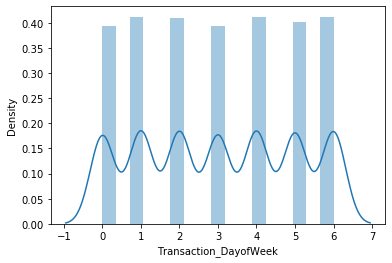

In [541]:
sns.distplot(df['Transaction_DayofWeek'], hist=True)

In [542]:
# Changing the DataType to 'int64'

for column in df.columns:
    if df[column].dtype == 'uint8':
        df[column] = df[column].astype(np.int64)
        
df.dtypes

Age                          int64
Fraud_Flag                   int64
Transaction_Month            int64
Transaction_Day              int64
Transaction_DayofWeek        int64
Customer_Segment_Diamond     int64
Customer_Segment_Gold        int64
Customer_Segment_Platinum    int64
Card_Family_Gold             int64
Card_Family_Platinum         int64
Card_Family_Premium          int64
Transaction_Segment_SEG11    int64
Transaction_Segment_SEG12    int64
Transaction_Segment_SEG13    int64
Transaction_Segment_SEG14    int64
Transaction_Segment_SEG15    int64
Transaction_Segment_SEG16    int64
Transaction_Segment_SEG17    int64
Transaction_Segment_SEG18    int64
Transaction_Segment_SEG19    int64
Transaction_Segment_SEG20    int64
Transaction_Segment_SEG21    int64
Transaction_Segment_SEG22    int64
Transaction_Segment_SEG23    int64
Transaction_Segment_SEG24    int64
Transaction_Segment_SEG25    int64
Credit_Limit_1_200           int64
Credit_Limit_200_400         int64
Credit_Limit_400_600

In [543]:
#Separating the feature and the Label columns 

X=df.drop(labels='Fraud_Flag', axis=1)
y= df['Fraud_Flag']

In [573]:
# Importing Libaries for All Model selection, training, tuning and Testing

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC

In [546]:
# As the datapoints differ a lot in magnitude, we'll scale them

scaler=StandardScaler()
scaled_data=scaler.fit_transform(X)

In [547]:
# Spliting the Data for Train and Test

X_train,X_test,y_train,y_test = train_test_split(scaled_data,y,test_size=0.3,random_state=42)

LOGISTIC Regression

In [549]:

# logistic regression object
lr = LogisticRegression()
  
# train the model on train set
lr.fit(X_train, y_train.ravel())
  
predictions = lr.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2968
           1       0.00      0.00      0.00        32

    accuracy                           0.99      3000
   macro avg       0.49      0.50      0.50      3000
weighted avg       0.98      0.99      0.98      3000



As we can see in the result that for every '1' it's been predicted as '0'.
This concludes that our data is imbalanced and needs to be sampled before processing.

Using the below method for upsampling of the Minority Class(i.e. '1')
It will create new synthetic data for our dataset

# SMOTE(Synthetic Minority Oversampling Technique)

In [551]:
# Counts for the data before sampling

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Using SMOTE function on Scaled & Test data.

sm = SMOTE(random_state = 42)

X_train_res, y_train_res = sm.fit_sample(scaled_data, y)

#Check the Size after sampling 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

# Check the Count after Sampling 

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))


Before OverSampling, counts of label '1': 77
Before OverSampling, counts of label '0': 6923 

After OverSampling, the shape of train_X: (19782, 36)
After OverSampling, the shape of train_y: (19782,) 

After OverSampling, counts of label '1': 9891
After OverSampling, counts of label '0': 9891


Now the count for label '1' is equal to lable '0'. This would solve the imbalanced data issues.

## Model Selection

In [552]:
# Spliting the data from the results of Upsampling.

X_train,X_test,y_train,y_test = train_test_split(X_train_res,y_train_res,test_size=0.3,random_state=42)

1. LogisticRegression

In [553]:
lr1 = LogisticRegression()
lr1.fit(X_train, y_train)
predictions = lr1.predict(X_test)

# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.66      0.61      0.63      2997
           1       0.63      0.67      0.65      2938

    accuracy                           0.64      5935
   macro avg       0.64      0.64      0.64      5935
weighted avg       0.64      0.64      0.64      5935



In [554]:
confusion_matrix(y_test,predictions)


array([[1841, 1156],
       [ 963, 1975]], dtype=int64)

Better Results than imbalanced dataset.

2. XGBClassifier

In [563]:
# XGBClassifier

xgb = XGBClassifier()

In [556]:
y_pred = xgb.fit(X_train, y_train).predict(X_test)

In [565]:
# Accuracy Score

accuracy_score(y_test,y_pred)

0.995787700084246

In [558]:
# Entering all the possible values for the Grid Parameterization

param_grid = {
    
    'learning_rate':[1,0.5,0.1,0.01,0.001],
    'max_depth': [3,5,10,20],
    'n_estimators':[10,50,100,200]
}

#Creating an object of the Grid Search class

grid = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic'), param_grid=param_grid, cv=5,  verbose=3,n_jobs=-1)

In [559]:
#finding the best parameters

grid.fit(X_train, y_train)

In [561]:
# Checking the Best Parameters

grid.best_params_

In [457]:
# Passing the Values of Best Parameters

new_model=XGBClassifier(learning_rate= 0.1, max_depth= 10, n_estimators= 100)

# Training with New Hyperparameters

new_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [458]:
# Checking the Accuracy and Prediction

y_pred_new = new_model.predict(X_test)
predictions_new = [round(value) for value in y_pred_new]
accuracy_new = accuracy_score(y_test,predictions_new)
accuracy_new

0.9954507160909857

3. RANDOM FOREST

In [569]:
# DecisionTreeClassifier

clf2 = DecisionTreeClassifier(criterion = 'entropy', max_depth =24, min_samples_leaf= 1)

In [570]:
# Model Training with Random Values

clf2.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=24, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [571]:
# DecisionTreeClassifier Score

clf2.score(X_test,y_test)

0.9850042122999157

In [ ]:
# RandomForestClassifier

rand_clf = RandomForestClassifier(random_state=6)

In [462]:
# Model Training for RandomForestClassifier

rand_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)

In [463]:
# Score for RandomForestClassifier

rand_clf.score(X_test,y_test)

0.9942712721145746

In [464]:
# Entering all the possible range values for the Grid Parameterization

grid_param = {
    "n_estimators" : [90,100,115,130],
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(2,20,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'max_features' : ['auto','log2']
}

In [465]:
grid_search = GridSearchCV(estimator=rand_clf,param_grid=grid_param,cv=5,n_jobs =-1,verbose = 3)

In [572]:
grid_search.fit(X_train,y_train)

In [466]:
# HyperParameter Tuning of the RandomForestClassifier

rand_clf = RandomForestClassifier(criterion= 'entropy',
 max_depth = 12,
 max_features = 'log2',
 min_samples_leaf = 1,
 min_samples_split= 5,
 n_estimators = 90,random_state=6)

In [467]:
# Model Training RandomForestClassifier

rand_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=12, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)

In [468]:
# Score for RandomForestClassifier

rand_clf.score(X_test,y_test)

0.9860151642796967

4. SVM

In [469]:
# Model with Default Parameters SVC

model = SVC()
model.fit(X_train, y_train)

In [470]:
# print prediction results

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2997
           1       0.97      1.00      0.98      2938

    accuracy                           0.98      5935
   macro avg       0.98      0.98      0.98      5935
weighted avg       0.98      0.98      0.98      5935



In [574]:
# Entering all the possible range Values for the Grid Parameterization

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search

grid.fit(X_train, y_train)

In [ ]:
# Checking the best parameters

grid.best_params_
# {C=0.1, gamma=0.01, kernel=rbf}

In [473]:
# Training with the Best Parameter combination

model = SVC(C=0.1, gamma=0.01, kernel='rbf')
model.fit(X_train, y_train)


SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [475]:
grid_predictions = model.predict(X_test)
  
#Classification report

print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      2997
           1       0.88      0.92      0.90      2938

    accuracy                           0.89      5935
   macro avg       0.90      0.89      0.89      5935
weighted avg       0.90      0.89      0.89      5935



Now we've some better result than previous Models.